# Recommendation Engines

This carries on the work from "recommend.ipynb", which did some exploratory analysis, and tried to develop some computation methods based
on using dense matrices built via the pivot table function.  This work will try to work with sparse matrices, and write the functions that are required.  In particular, I intend to attempt both user-user and item-item collaborative filtering.

I would also like to attempt latent factor analysis.  The existing routines for matrix factorization reconstruct an entire matrix, rather than just a sub-portion.  I might try using stochastic gradient descent to carry out this factorization. 

In [1]:
#Libraries
#standard library imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sparse

%load_ext autoreload
%autoreload 2

%matplotlib inline

#save graphics as pdf too (for less revolting exported plots)
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

In [2]:
%autosave 600 

Autosaving every 600 seconds


In [5]:
#read in the data.  (13MB or so)
#(N.B. I put Matt's header on it's own line, which is skipped, and added the UserID)
#initial playing data
#frequent users
#df=pd.read_csv('data/boardgame-frequent-users.csv',skiprows=1)

#full matrix (2E5 users, 400 games)
df=pd.read_csv('data/boardgame-users.csv',skiprows=1)
df.columns=('userID','gameID','rating')

detail_df=pd.read_csv('data/boardgame-details.csv',index_col=0)
name_dict=detail_df['title'].to_dict()

In [ ]:
#split the dataframe for k-fold cross-validation.

#find users with only 1 review.  


In [6]:
#find unique entries
users=df['userID'].unique()
games=df['gameID'].unique()

Nusers = len(users)
Ngames = len(games)
print('Nusers:{}, Ngames:{}'.format(Nusers,Ngames))

#sort the list.
users.sort()
games.sort()

#make a dict of user/games for correspondence between IDs and row/columns.
user_dict=dict(zip(users,np.arange(Nusers)))
game_dict=dict(zip(games,np.arange(Ngames)))

Nusers:193504, Ngames:402


In [8]:
#extract indices
score_row = np.array([user_dict[v] for v in df['userID'].values])
score_col = np.array([game_dict[v] for v in df['gameID'].values])
score_val = df['rating'].values

#subtract off mean score per user.
user_mean=np.zeros(Nusers)
score_val_u=np.zeros(score_val.shape)
single_users=[]
low_users=[]
for i in range(Nusers):
    msk= score_row==i
    mu=np.mean(score_val[msk])
    user_mean[i]=mu
    score_val_u[msk] = score_val[msk]-mu
    #grab single users.
    if (np.sum(msk)==1):
        single_users.append(i)
    if (np.sum(msk)<=5):
        low_users.append(i)
    if (i%1000==0):
        print('On user {} of {}'.format(i,Nusers))

#subtract off mean score per user.
game_mean=np.zeros(Ngames)
score_val_g=np.zeros(score_val.shape)
for i in range(Ngames):
    msk= score_col==i
    mu=np.mean(score_val[msk])
    game_mean[i]=mu
    score_val_g[msk] = score_val[msk]-mu


On user 0 of 193504
On user 1000 of 193504
On user 2000 of 193504


KeyboardInterrupt: 

In [13]:
np.diff(df['userID']).le

AttributeError: 'numpy.ndarray' object has no attribute 'len'

In [7]:
score_val.shape

(528871,)

In [8]:
#make a coordinate sparse matrix, then convert it.
score_coo = sparse.coo_matrix((score_val_g,(score_row,score_col)))
#convert to either compressed row or column matrix. (csr, csc)
#use R fast row slicing, and fast arithmetic
score_R = score_coo.tocsr()
score_C = score_coo.tocsc()

In [9]:
score_coo.shape

(2473, 402)

In [ ]:
#Cross-validation by selecting out a subset of scores.
#Select out reviewers with more than one review.  
np.random.seed(seed=27128)
Nfold=5
#array of integer indices
nu = np.arange(Nusers)
ng = np.arange(Ngames)

#shuffled set of that data
np.random.shuffle(nu)
np.random.shuffle(ng)

#make a list of uniform random numbers (times appropriate lengths)
pick_class=0
game_ix= (ng%5)==pick_class
user_ix= (nu%5)==pick_class

# PCA

Let's try doing a PCA for dimensionality reduction.  Also do some clustering, and maybe even some filtering.  

In [51]:
from IPython.core.debugger import set_trace

import warnings

warnings.filterwarnings('error', "RuntimeWarning: invalid value encountered in true_divide")
%pdb OFF

Automatic pdb calling has been turned OFF


In [19]:
from sklearn.decomposition import TruncatedSVD

In [20]:
%pdb OFF
svd=TruncatedSVD(n_components=5,random_state=439,n_iter=1000)
# %debug --breakpoint /home/jonathan/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/truncated_svd.py:187

score_pca=svd.fit_transform(score_R)

Automatic pdb calling has been turned OFF


In [21]:
comp=svd.components_
exp_var=svd.explained_variance_
#reconstruct the matrix by adding up components again.
score_recon=np.dot(score_pca,comp)
score_full=score_R.toarray()

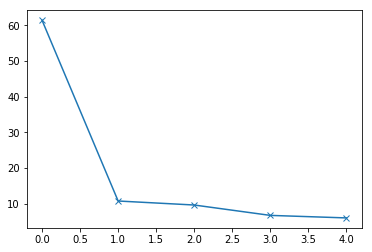

In [22]:
plt.plot(exp_var,'-x')
plt.show()

In [24]:
diff=score_recon-score_full
cost=np.sum(np.abs(diff)/(Nusers*Ngames))
print(cost)
print(diff[0:5,0:5])

0.592313877564
[[ 0.38650579  0.32182079  0.13009365  0.1543331  -0.10450587]
 [ 0.40596635  0.00233083 -0.20857872 -1.367775   -0.15081522]
 [-0.25777031 -0.19457546 -0.01022145 -0.60538809 -0.53606796]
 [-0.0104767   0.57551235 -0.04993931  0.08202462  0.03743651]
 [ 0.58054752  0.36785332  0.24405721  1.08269932 -0.16995015]]


In [56]:
#Plot the components against one another.
def plot_comp(score_pca):
    nc=score_pca.shape[1]
    print(nc)
    plt.figure(figsize=(10,10))
    for i in range(nc):
        for j in range(i,nc):
            plt.subplot(nc,nc,j+i*nc+1)
            plt.scatter(score_pca[:,i],score_pca[:,j],marker='x')

    plt.show()            
    return
plot_comp(score_pca)
            


8 8
8 9
9 9
7 7
7 8
7 96 7
6 8
6 9
5 8
5 9
6 6
5 5
5 6
5 7
4 7
4 8
4 9
4 4
4 5
4 6
3 7
3 8
3 9
 4
3 5
3 6
2 9
3 3
32 6
2 7
2 8
2 3
2 4
2 5
1 8
1 9
2 2
1 5
1 6
1 7
1 2
1 3
1 4
0 8
0 9
1 1
0 5
0 6
0 7
0 2
0 3
0 4
10
0 0
0 1


Evidently, there is not much to differentiate users based solely on their scores.  (Again, other people at the workshop commented on exactly this - they suggested there was more variation for a PCA based on games.)  Let us try the same PCA on the transposed matrix.  

In [84]:
score_pca_T=svd.fit_transform(score_C.T)

(402, 5)

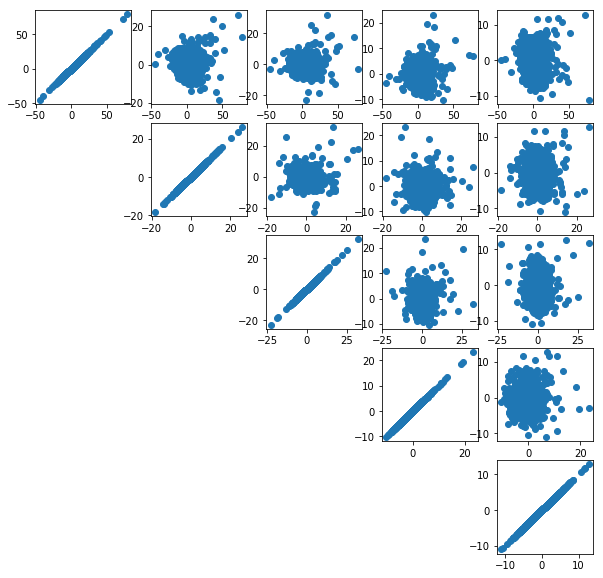

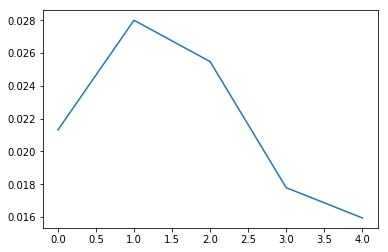

In [92]:
score_pca_T.shape
plt.plot(svd.explained_variance_ratio_)
plt.show()
plot_comp(score_pca)

Once again, this seems to have just found a big blob, which suggests that clustering is not meaningful.  (These are for the normalized scores where the average score for each game has been subtracted, before carrying out the PCA).  

A simple recommendation algorithm could be designed by using the reduced dimensions to carry out k-nearest neighbours.  It would be slow for large matrices.  Let's try this now for the reduced data set after the SVD. 

In [41]:
np.sum(score_pca*score_pca,axis=1)

array([  39.35988911,   23.99746831,   40.18258126, ...,   38.87677693,  171.67284391,   40.57915161])

In [45]:
Knn = 10
nvec = np.arange(Nusers).astype(int)

idx_array = np.zeros([Nusers,Knn])
#make an array of indices of nearest neighbours.
dnorm = np.sum(score_pca*score_pca,axis=1)

for i in range(Nusers):
    #calculate |v_i - v_j|^2 for all vectors.   
    dvec=dnorm[i]**2 - 2*np.dot(score_pca,score_pca[i,:].T)+dnorm**2
    #ignore the values for any identical vectors
    dvec[dvec==0]=np.max(dvec)
    dmat=np.array([dvec,nvec])
    #the following sorts the array based on the values in the first row
    idx = np.argsort(dmat[0])
    #grab last Knn entries since sorted in ascending order.
    idx_array[i,:]=idx[:Knn]

In [46]:
#make up vectors.
kmat = np.zeros(score_pca.shape)
for i in range(Nusers):
    ai = score_pca[i]
    kvec=np.zeros(ai.shape)
    for idx in idx_array[i]:
        vj = score_pca[np.int(idx)]
        v_norm=np.dot(vj,vj.T)
        kvec += np.dot(ai,vj.T)/v_norm*(vj)
    kmat[i]=kvec

In [47]:
print(kmat[0:5])
print(score_pca[0:5])

[[-24.81124227 -12.20737558  -6.01236285  -4.22961506   8.19159786]
 [  2.84880633  -8.97626212  -3.77494725 -20.55481635  -0.65267763]
 [ 18.49725774  -0.49910491  12.10706609  13.59896053  19.69734593]
 [ -5.16672454  -0.62825222   0.28918555  -7.49676265  -7.0854568 ]
 [-19.10398172  -4.82197861   0.76085909   0.81799849   7.71298224]]
[[-5.71060411 -2.48102002 -0.15599939 -0.75286063 -0.04790094]
 [ 1.08208226 -2.21546958 -0.53473732 -3.72010125 -1.94760456]
 [ 4.92739943 -0.90350248  1.56479807  2.69635511  2.31691077]
 [-2.82628778 -0.70687679  0.63864529 -1.17124864 -3.93932912]
 [-5.26869138 -0.73611451  1.20592093  0.28120331  0.56647573]]


In [47]:
idx_array[1250]

array([  370.,  1682.,  1778.,  1251.,  2198.])

In [49]:
plt.hist(idx_array)
plt.show()

In [19]:
idx_array.shape

(2473, 5)

In [103]:
dnorm

array([[  39.35988911,    2.29470957,  -28.28188908, ...,   21.58662739,
          72.54089086,    4.09421793],
       [   2.29470957,   23.99746831,   -8.0463622 , ...,    8.82009926,
          -1.69167873,    5.00156789],
       [ -28.28188908,   -8.0463622 ,   40.18258126, ...,  -20.71462527,
         -55.98606086,    4.13452836],
       ..., 
       [  21.58662739,    8.82009926,  -20.71462527, ...,   38.87677693,
          10.01308011,   29.60866848],
       [  72.54089086,   -1.69167873,  -55.98606086, ...,   10.01308011,
         171.67284391,  -27.68291711],
       [   4.09421793,    5.00156789,    4.13452836, ...,   29.60866848,
         -27.68291711,   40.57915161]])

# Latent Factor Analysis

Here we will try to factor the scoring matrix $S=WH$, subject to the cost function:
\begin{align}
J &= \sum_{i,j \in S_{ij}\ne 0} \left(S_{ij} - \sum_{k=1}^{N_f}W_{ik}H_{kj}\right)^2
&+\lambda^{(1)} \sum_{i,j} |W_{ij}|+\lambda^{(1)} \sum_{i,j} |H_{ij}|\nonumber\\
  &+\lambda^{(2)} \sum_{i,j} |W_{ij}|^2+\lambda^{(2)} \sum_{i,j} |H_{ij}|^2\nonumber.
  \end{align}
Similar to other problems, the $\lambda^{(1)}$ regularization enforces sparsity on the problem.  Could we also put in some sort of AIC correction based on the number of degrees of freedom? Something like $N_f^2$?
  
We can then test the method on how well it recreates existing scores,
and make predictions based on the scores for games the user has not rated.  

\begin{align}
    \frac{\partial_{J}}{\partial W_{nm}} & = \sum_{ij\ne 0} \delta_{in}H_{mj}(S_{ij} -\sum_{k=1}^{N_f}W_{im}H_{mj})
    +\lambda^{(1)}+\lambda^{(2)}W_{nm}
\end{align}


In [ ]:
#Do Stochastic Gradient Descent on
W = np.zeros((Nusers,Nf))
H = np.zeros((Nf,Ngames))

def cost(R,W,H,l1,l2,lN):
    """cost(R,W,H)
    Return cost function
    """
    
    J = 0
    nrows,ncols=R.shape
    for i in range(nrows):
        for j in range(ncols):
            J+= (R[i,j]- np.dot(W[i,:],H[:,j]))**2 
            
    J+= l1*np.sum(W) +l1*np.sum(H) + l2*np.sum(W*W)+l2*np.sum(H*H) + lN*Nf*Nf
    return J 

def gradW(R,W,H,l1,l2,lN):
    """gradW
    Calculate derivatives of cost w.r.t. W 
    """
    gW = 
    gW = l1*(W>0) + l2*W
    return gW

In [19]:
r = np.random.random((3,3))
np.sum(r)

4.740640165451727